In [2]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

device

'cuda'

In [3]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [4]:
# Turn data into a DataFrame
import pandas as pd
moons = pd.DataFrame({
    "X0" : X[:,0],
    "X1" : X[:,1],
    "labels" : y
})
moons.head()

,X0,X1,labels
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


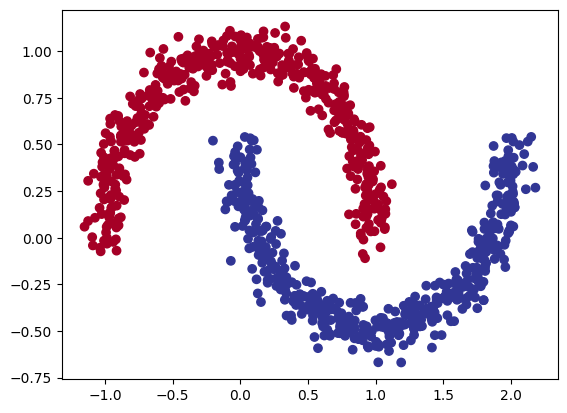

In [5]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);


In [6]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype = torch.float)
y = torch.tensor(y, dtype = torch.float)
print(X.dtype,y.dtype)
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8)
len(X_train), len(X_test), len(y_train), len(y_test)


torch.float32 torch.float32


(800, 200, 800, 200)

In [12]:
import torch
from torch import nn


class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.relu = nn.ReLU()  # ReLU as a layer
        self.layer2 = nn.Linear(in_features=16, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [35]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() #sigmoid layer built in
# Setup optimizer 
optimizer = torch.optim.SGD(model_0.parameters(),lr = 0.1)

In [36]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


# logits (raw outputs of model)
logits = model_0(X_train.squeeze())
print("Logits:",logits[:5])
# Prediction probabilities
pred_prob = torch.sigmoid(logits.squeeze())
print("Pred probs:",pred_prob[:5])
# Prediction labels
pred_labels = torch.round(pred_prob.squeeze())
print("Pred labels:",pred_labels[:5])


Logits: tensor([[ 0.8758],
        [-1.4097],
        [ 1.1005],
        [ 0.8043],
        [-0.3589]], device='cuda:0', grad_fn=<SliceBackward0>)
Pred probs: tensor([0.7059, 0.1963, 0.7504, 0.6909, 0.4112], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred labels: tensor([1., 0., 1., 1., 0.], device='cuda:0', grad_fn=<SliceBackward0>)


In [38]:

from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [39]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000


# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  y_logits = model_0(X_train)
  pred_label = torch.round(torch.sigmoid(model_0(X_train.squeeze())))

  loss = loss_fn(y_logits.squeeze(), y_train) # loss = compare model raw outputs to desired model outputs

  acc = acc_fn(pred_label.squeeze(), y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    y_test_logits = model_0(X_test.squeeze())
    y_test_pred = torch.sigmoid(y_test_logits.squeeze())
    y_test_labels = torch.round(y_test_pred.squeeze())

    loss_test = loss_fn(y_test_logits.squeeze(),y_test)
    acc_test = acc_fn(y_test_labels.squeeze(),y_test.int())
  if epoch % 100 == 0:
    print(f"loss:{loss} | test_loss:{loss_test} | acc :{acc} | test_acc :{acc_test}")


loss:0.34580832719802856 | test_loss:0.33662623167037964 | acc :0.8324999809265137 | test_acc :0.8399999737739563
loss:0.22495068609714508 | test_loss:0.2192995846271515 | acc :0.8999999761581421 | test_acc :0.8949999809265137
loss:0.18074931204319 | test_loss:0.1797485649585724 | acc :0.9175000190734863 | test_acc :0.925000011920929
loss:0.13982465863227844 | test_loss:0.14034532010555267 | acc :0.9350000023841858 | test_acc :0.9399999976158142
loss:0.09659070521593094 | test_loss:0.09586858749389648 | acc :0.96875 | test_acc :0.9649999737739563
loss:0.06247947737574577 | test_loss:0.06026161462068558 | acc :0.9825000166893005 | test_acc :0.9950000047683716
loss:0.04151858761906624 | test_loss:0.0389651395380497 | acc :0.9950000047683716 | test_acc :0.9950000047683716
loss:0.029459316283464432 | test_loss:0.026905512437224388 | acc :0.9975000023841858 | test_acc :0.9950000047683716
loss:0.02221761830151081 | test_loss:0.019868483766913414 | acc :1.0 | test_acc :1.0
loss:0.017545592039

In [41]:
import numpy as np

def plot_decision_boundary(model, X, y):

    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

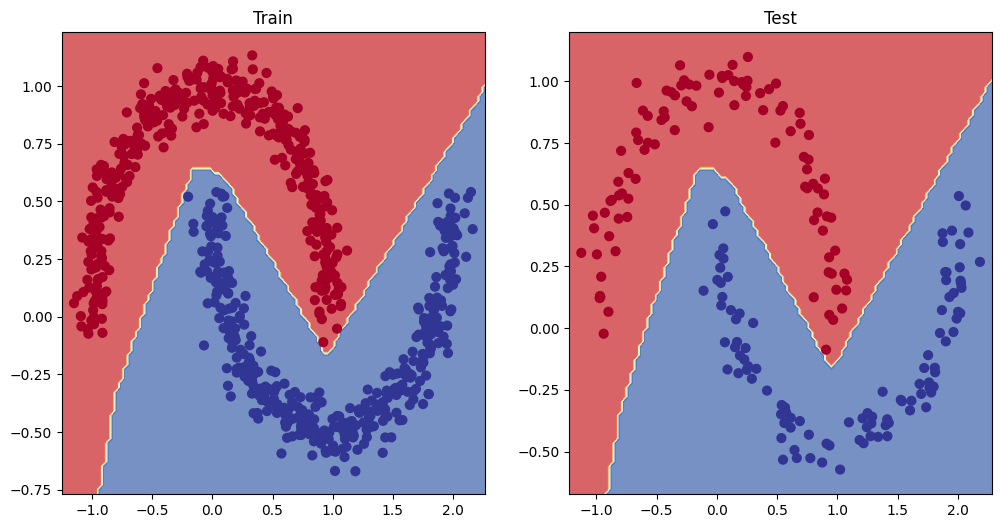

In [43]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
